# Query Generation Using LLAMA 3.2

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Load LLAMA 3.2 3B and Inference](#2)
  - [ 2.1 - Load Model](#2.1)
  - [ 2.2 - Load Data](#2.2)  
  - [ 2.3 - Run Inference](#2.3)
- [ 3 - Analyze the output](#3)
  - [ 3.1 - Check Response Semantic Similarity](#3.1)
  - [ 3.2 - Check Response quality](#3.2)  

In this notebook, you will use LLAMA 3.2 3B Instruct to generate query reformulation using ExLLamaV2 GPU

# Table of Contents

<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

In [ ]:
!pip install --upgrade pip uv
!uv pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet \
    exllamav2 \ 
    sentence-transformers

<a name='2'></a>
## 2 - Load LLAMA 3.2 3B and Inference

<a name='2.1'></a>
### 2.1 - Load Model

In [ ]:
import json 

import pandas as pd
import torch


from exllamav2 import ExLlamaV2, ExLlamaV2Config, ExLlamaV2Cache, ExLlamaV2Tokenizer, ExLlamaV2Cache_Q6, ExLlamaV2Cache_Q4, ExLlamaV2Cache_Q8
from exllamav2.generator import ExLlamaV2DynamicGenerator, ExLlamaV2DynamicJob, ExLlamaV2Sampler

from exllamav2 import ExLlamaV2, ExLlamaV2Config, ExLlamaV2Cache, ExLlamaV2Tokenizer, Timer
from exllamav2.generator import ExLlamaV2DynamicGenerator
from exllamav2 import ExLlamaV2, ExLlamaV2Config, ExLlamaV2Cache_TP, ExLlamaV2Tokenizer, Timer

model_dir = "/home/ubuntu/.cache/huggingface/hub/models--turboderp--Llama-3.2-3B-Instruct-exl2/snapshots/48320f1ccf9eddd5cca80db7b107e80672c5c32a"
config = ExLlamaV2Config(model_dir)
config.arch_compat_overrides()
config.no_graphs = True
model = ExLlamaV2(config)

# accounted for when splitting the model.

qbit = int(json.load(open(config.model_config))["quantization_config"]["bits"])

if qbit==4:
    cache_type = ExLlamaV2Cache_Q4
elif qbit==6:
    cache_type = ExLlamaV2Cache_Q6
elif qbit==8:
    cache_type = ExLlamaV2Cache_Q8
else:
    cache_type = ExLlamaV2Cache
    
cache = cache_type(
    model,
    max_seq_len=4096,
)

if torch.cuda.device_count() == 1:
    print("Use cache: ", cache)
    model.load_autosplit(cache, progress = True)
else:
    print("Use cache:i ", cache)
    model.load_tp(expect_cache_tokens=16384, progress=True)    
    cache = ExLlamaV2Cache_TP(model, max_seq_len = 16384)

# After loading the model, all other functions should work the same

print("Loading tokenizer...")
tokenizer = ExLlamaV2Tokenizer(config)

In [ ]:
# Initialize the generator with all default parameters
generator = ExLlamaV2DynamicGenerator(
    model = model,
    cache = cache,
    tokenizer = tokenizer,
    paged=False
)

In [ ]:
# Initialize the generator with all default parameters
def format_prompt(prompt_format: str, sp: str, p: str):
    """
    Format prompt template by model type
    Args:
        prompt_format: str, model type
        sp: str, system prompt
        p: str, user prompt
    """
    if prompt_format == "llama":
        return f"<s>[INST] <<SYS>>\n{sp}\n<</SYS>>\n\n{p} [/INST]"
    elif prompt_format == "llama3":
        return (
            f"<|begin_of_text|>"
            f"<|start_header_id|>system<|end_header_id|>\n\n"
            f"{sp}<|eot_id|>"
            f"<|start_header_id|>user<|end_header_id|>\n\n"
            f"{p}<|eot_id|>"
            f"<|start_header_id|>assistant<|end_header_id|>\n\n"
        )
    elif prompt_format == "granite":
        return f"System:\n" f"{sp}\n\n" f"Question:\n" f"{p}\n\n" f"Answer:\n"
    elif prompt_format == "chatml":
        return (
            f"<|im_start|>system\n"
            f"{sp}<|im_end|>\n"
            f"<|im_start|>user\n"
            f"{p}<|im_end|>\n"
            f"<|im_start|>assistant\n"
        )
    elif prompt_format == "gemma":
        return (
            f"<bos><start_of_turn>user\n"
            f"{sp}\n\n"
            f"{p}<end_of_turn>\n"
            f"<start_of_turn>model\n"
        )


def get_stop_conditions(prompt_format, tokenizer):
    if prompt_format == "llama":
        return [tokenizer.eos_token_id]
    elif prompt_format == "llama3":
        return [tokenizer.single_id("<|eot_id|>")]
    elif prompt_format == "granite":
        return [tokenizer.eos_token_id, "\n\nQuestion:"]
    elif prompt_format == "gemma":
        return [tokenizer.eos_token_id, "<end_of_turn>"]

In [ ]:
prompt_template = """
### Instruction: Generate adequate search engine queries to obtain requested information based on input query. Return in YAML list only, at most 2 items,always start and close with triple backslash ```yml

### Example:
Query: In what year was the winner of the 44th edition of the Miss World competition born?
Response: 
```yaml
- 44th Miss World competition winner birth year
```

Query: Who lived longer, Nikola Tesla or Milutin Milankovic?
Response: 
```yaml
- Nikola Tesla lifespan
- Milutin Milankovic lifespan
```

Query: Author David Chanoff has collaborated with a U.S. Navy admiral who served as the ambassador to the United Kingdom under which President?
Response:
```yaml
- David Chanoff U.S. Navy admiral collaboration
- U.S. Navy admiral ambassador to United Kingdom
- U.S. President during U.S. Navy admiral's ambassadorship
```

Query: Create a table for top noise cancelling headphones that are not expensive
Response:
```yaml
- top noise cancelling headphones under $100
- top noise cancelling headphones $100 - $200
- best budget noise cancelling headphones
- noise cancelling headphones reviews
```
### Input
Query: {query}
### Response
"""

<a name='2.2'></a>
### 2.2 - Load Data

In [ ]:
import polars as pl

splits = {'validation': 'v1.1/validation-00000-of-00001.parquet', 'train': 'v1.1/*', 'test': 'v1.1/test-00000-of-00001.parquet'}
df = pl.read_parquet('hf://datasets/microsoft/ms_marco/' + splits['train'])

In [ ]:
df.head()

In [ ]:
df["query"].n_unique()

In [ ]:
# queries = df["query"].sample(1000)
queries = df["query"]

In [ ]:
prompt_format = "llama3"
prompts = [format_prompt(prompt_format,p=prompt_template.format(query=queries[i]),sp="") for i in range(len(queries))]

<a name='2.3'></a>
### 2.3 - Run Inference

In [ ]:
import time
from tqdm import tqdm

gen_settings = ExLlamaV2Sampler.Settings(
    token_repetition_penalty = 1.1,
    temperature = 0.3,
    top_k = 40,
    top_p = 0.95,
)
max_response_len = 32

completions = []

for idx, f_prompt in enumerate(prompts):
    completions.append(f_prompt)
    prompt_ids = tokenizer.encode(f_prompt, encode_special_tokens = True)
    job = ExLlamaV2DynamicJob(
        input_ids = prompt_ids,
        gen_settings = gen_settings,
        max_new_tokens = max_response_len,
        identifier = idx,
        stop_conditions = get_stop_conditions(prompt_format, tokenizer), 
    )
    generator.enqueue(job)
    if (idx + 1) % 1000 == 0 or (idx + 1) == len(prompts):
        print(f"{idx + 1} / {len(prompts)}")

# Generate

print()
print("Generating...")

num_completions = 0
num_tokens = 0
time_begin = time.time()

with Timer() as t_batched, tqdm(total=len(prompts)) as pbar:
    while generator.num_remaining_jobs():
        results = generator.iterate()
    
        # We'll always get at least one result for each active job, even if the result contains no output text
        bsz = len(set([r["identifier"] for r in results]))
        num_tokens += bsz
    
        for result in results:
            if not result["eos"]: continue
    
            # EOS signal is always accompanied by the full completion, so we don't need to collect text chunks
            idx = result["identifier"]
            response = result["full_completion"]
            completions[idx] = {"response": response}
    
            # Measure performance
            num_completions += 1
            elapsed_time = time.time() - time_begin
            rpm = num_completions / (elapsed_time / 60)
            tps = num_tokens / elapsed_time
            pbar.update(1)

In [ ]:
import yaml
def parse_queries(text):
    lindex, rindex = text.find("```yaml"),  text.rfind("```")
    if rindex <= 0:
        rindex = -1
    try:
        return yaml.safe_load(text[lindex+7:rindex])
    except Exception as e:
        return []

In [ ]:
data_labels = []
for i in range(len(completions)):
    alternative_queries = parse_queries(completions[i]["response"])
    if not alternative_queries:
        print(i)
        continue
    for q in alternative_queries:
        data_labels.append({"query": queries[i], "alternative": q})

<a name='3'></a>
### 3 - Analyze the output

<a name='3.1 '></a>
### 3.1 - Check Response Semantic Similarity

Ideally, we want to get the output of query reformulation is closely meaning with origin query but it is more clarify and concise. So we check semantic 

In [2]:
from sentence_transformers import SentenceTransformer, util

/opt/homebrew/Caskroom/miniconda/base/envs/semantic_search/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/opt/homebrew/Caskroom/miniconda/base/envs/semantic_search/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/semantic_search/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /opt/homebrew/Caskroom/miniconda/base/envs/semantic_search/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /opt/homebrew/Caskroom/miniconda/base/envs/semantic_search/lib/python3.10/site-packages/torch/lib/libtor

In [ ]:
df = pd.DataFrame(data_labels)
df["alternative"] = df["alternative"].astype(str)

In [ ]:
df.head()

In [ ]:
model_id = "nomic-ai/nomic-embed-text-v1.5"
sbert = SentenceTransformer(model_id, device="cuda", trust_remote_code=True)

In [ ]:
from tqdm import trange
import numpy as np
all_scores = np.zeros(len(df))
batch_size = 512
for i in trange(0, len(df), batch_size):
    queries_embedding = sbert.encode(df["query"].iloc[i: i+batch_size].tolist(), batch_size=512, show_progress_bar=False, normalize_embeddings=True, convert_to_numpy=True)
    alternative_embedding = sbert.encode(df["alternative"].iloc[i: i+batch_size].tolist(), batch_size=512, show_progress_bar=False, normalize_embeddings=True, convert_to_numpy=True)
    scores = util.pairwise_dot_score(queries_embedding, alternative_embedding).detach().numpy()
    all_scores[i: i + batch_size] = scores

df["semantic_score"] = all_scores    

In [7]:
import pandas as pd
df = pd.read_parquet("~/Downloads/sample_query_rewrite_full.parquet")

In [8]:
df["semantic_score"].describe()

count    206022.000000
mean          0.829778
std           0.157775
min          -0.112433
25%           0.775642
50%           0.867698
75%           0.935892
max           1.000000
Name: semantic_score, dtype: float64

<Axes: >

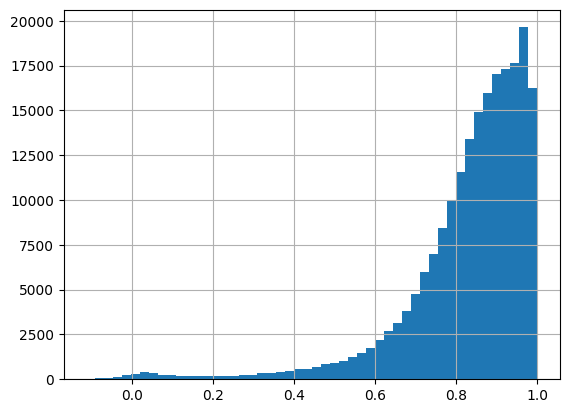

In [9]:
df["semantic_score"].hist(bins=50)

<a name='3.2'></a>
### 3.2 - Check Response Quality Text

In [10]:
from sklearn.model_selection import train_test_split

In [ ]:
df["num_query"] = df["query"].map(lambda d: len(d.split()))
df["num_alternative"] = df["alternative"].map(lambda d: len(d.strip().split()))

In [ ]:
df_filter = df[(df["num_alternative"]>=2)&(df["semantic_score"]>=0.7)]

In [ ]:
short_tokens = 5
df_sample = pd.concat([
    df_filter[df_filter["num_query"]<=short_tokens].sample(frac=0.5),
    df_filter[df_filter["num_query"]>short_tokens],
]).sample(frac=1.0)

In [ ]:
df_train, df_test = train_test_split(df_sample, test_size=0.1, shuffle=True, random_state=4111)

In [ ]:
df_train.to_parquet("train.parquet", index=False)
df_test.to_parquet("test.parquet", index=False)